In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [77]:
df_train = pd.read_csv('../train.csv')
df_train['dataset'] = 'train'
print(df_train.shape)
df_train.head()

(10886, 13)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dataset
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [326]:
df_test = pd.read_csv('../test.csv')
df_test['dataset'] = 'test'
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
print(df_test.shape)
df_test.head()

(6493, 10)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dataset
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test


In [414]:
df = df_train.copy().append(df_test.copy())
df.shape

(17379, 13)

In [415]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df = df.drop('datetime', axis=1)
drange = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df = df.reindex(drange)
print(df.shape)
df.head()

(17544, 12)


,atemp,casual,count,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday
2011-01-01 00:00:00,14.395,3.0,16.0,train,0.0,81.0,13.0,1.0,9.84,1.0,0.0,0.0
2011-01-01 01:00:00,13.635,8.0,40.0,train,0.0,80.0,32.0,1.0,9.02,1.0,0.0,0.0
2011-01-01 02:00:00,13.635,5.0,32.0,train,0.0,80.0,27.0,1.0,9.02,1.0,0.0,0.0
2011-01-01 03:00:00,14.395,3.0,13.0,train,0.0,75.0,10.0,1.0,9.84,1.0,0.0,0.0
2011-01-01 04:00:00,14.395,0.0,1.0,train,0.0,75.0,1.0,1.0,9.84,1.0,0.0,0.0


In [416]:
missing = df[pd.isnull(df['atemp'])]
missing.shape

(165, 12)

In [417]:
df['atemp'] = df['atemp'].interpolate(method='time')
df['holiday'] = df['holiday'].interpolate(method='time').apply(np.round)
df['humidity'] = df['humidity'].interpolate(method='time').apply(np.round)
df['season'] = df['season'].interpolate(method='time').apply(np.round)
df['temp'] = df['temp'].interpolate(method='time')
df['weather'] = df['weather'].interpolate(method='time').apply(np.round)
df['windspeed'] = df['windspeed'].interpolate(method='time')
df['workingday'] = df['workingday'].interpolate(method='time').apply(np.round)
df['casual'] = df['casual'].interpolate(method='time').apply(np.round)
df['registered'] = df['registered'].interpolate(method='time').apply(np.round)
df['count'] = df['count'].interpolate(method='time').apply(np.round)

In [418]:
df.loc[missing.index, 'dataset'] = 'train'
for year in [2011,2012]:
    for m in np.arange(1,13):
        df.loc[pd.datetime(year,m,20):pd.datetime(year,m,20)+pd.tseries.offsets.MonthEnd(),'dataset'] = 'test'
#         df = df.drop(df[df['dataset']=='train'].loc[pd.datetime(year,m,20):pd.datetime(year,m,20)+pd.tseries.offsets.MonthEnd()].index)
df.shape

(17544, 12)

In [419]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
print(df.shape)
df.head()

(17544, 16)


,atemp,casual,count,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday,month,day,dayofweek,hour
2011-01-01 00:00:00,14.395,3.0,16.0,train,0.0,81.0,13.0,1.0,9.84,1.0,0.0,0.0,1,1,5,0
2011-01-01 01:00:00,13.635,8.0,40.0,train,0.0,80.0,32.0,1.0,9.02,1.0,0.0,0.0,1,1,5,1
2011-01-01 02:00:00,13.635,5.0,32.0,train,0.0,80.0,27.0,1.0,9.02,1.0,0.0,0.0,1,1,5,2
2011-01-01 03:00:00,14.395,3.0,13.0,train,0.0,75.0,10.0,1.0,9.84,1.0,0.0,0.0,1,1,5,3
2011-01-01 04:00:00,14.395,0.0,1.0,train,0.0,75.0,1.0,1.0,9.84,1.0,0.0,0.0,1,1,5,4


In [422]:
# tax day
df.loc[pd.datetime(2011,4,15,0):pd.datetime(2011,4,15,23), 'workingday'] = 1
df.loc[pd.datetime(2011,4,15,0):pd.datetime(2011,4,15,23), 'holiday'] = 0
df.loc[pd.datetime(2012,4,16,0):pd.datetime(2012,4,16,23), 'workingday'] = 1
df.loc[pd.datetime(2012,4,16,0):pd.datetime(2012,4,16,23), 'holiday'] = 0

# thanksgiving friday
df.loc[pd.datetime(2011,11,25,0):pd.datetime(2011,11,25,23), 'workingday'] = 0
df.loc[pd.datetime(2011,11,25,0):pd.datetime(2011,11,25,23), 'holiday'] = 1
df.loc[pd.datetime(2012,11,23,0):pd.datetime(2012,11,23,23), 'workingday'] = 0
df.loc[pd.datetime(2012,11,23,0):pd.datetime(2012,11,23,23), 'holiday'] = 1

# christmas eve
df.loc[pd.datetime(2011,12,24,0):pd.datetime(2011,12,24,23), 'workingday'] = 0
df.loc[pd.datetime(2011,12,24,0):pd.datetime(2011,12,24,23), 'holiday'] = 1
df.loc[pd.datetime(2012,12,24,0):pd.datetime(2012,12,24,23), 'workingday'] = 0
df.loc[pd.datetime(2012,12,24,0):pd.datetime(2012,12,24,23), 'holiday'] = 1

# new year
df.loc[pd.datetime(2011,12,31,0):pd.datetime(2011,12,31,23), 'workingday'] = 0
df.loc[pd.datetime(2011,12,31,0):pd.datetime(2011,12,31,23), 'holiday'] = 1
df.loc[pd.datetime(2012,12,31,0):pd.datetime(2012,12,31,23), 'workingday'] = 0
df.loc[pd.datetime(2012,12,31,0):pd.datetime(2012,12,31,23), 'holiday'] = 1

In [423]:
cr_w_from = 7
cr_w_to = 23
cr_nw_from = 10
cr_nw_to = 19
rr_w_from1 = 7
rr_w_to1 = 9
rr_w_from2 = 12
rr_w_to2 = 21
rr_nw_from = 8
rr_nw_to = 23
df['casual_rush'] = df[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
df['registered_rush'] = df[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
#         (x['workingday'] == 1 and  rr_w_from1 <= x['hour'] <= rr_w_to2)
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
df.head()

,atemp,casual,count,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday,month,day,dayofweek,hour,casual_rush,registered_rush
2011-01-01 00:00:00,14.395,3.0,16.0,train,0.0,81.0,13.0,1.0,9.84,1.0,0.0,0.0,1,1,5,0,0,0
2011-01-01 01:00:00,13.635,8.0,40.0,train,0.0,80.0,32.0,1.0,9.02,1.0,0.0,0.0,1,1,5,1,0,0
2011-01-01 02:00:00,13.635,5.0,32.0,train,0.0,80.0,27.0,1.0,9.02,1.0,0.0,0.0,1,1,5,2,0,0
2011-01-01 03:00:00,14.395,3.0,13.0,train,0.0,75.0,10.0,1.0,9.84,1.0,0.0,0.0,1,1,5,3,0,0
2011-01-01 04:00:00,14.395,0.0,1.0,train,0.0,75.0,1.0,1.0,9.84,1.0,0.0,0.0,1,1,5,4,0,0


In [424]:
features_common = ['humidity','atemp','temp','windspeed','weather','season','holiday','workingday','month','day','dayofweek','hour']
features_casual = features_common + ['casual_rush']
features_registered = features_common + ['registered_rush']

In [425]:
x_cas_11 = df[df['dataset']=='train'].loc['2011-01':'2011-12'][features_casual]
x_cas_12 = df[df['dataset']=='train'].loc['2012-01':'2012-12'][features_casual]
x_reg_11 = df[df['dataset']=='train'].loc['2011-01':'2011-12'][features_registered]
x_reg_12 = df[df['dataset']=='train'].loc['2012-01':'2012-12'][features_registered]
print(x_cas_11.shape)
print(x_cas_12.shape)
print(x_reg_11.shape)
print(x_reg_12.shape)
y_cas_11 = df[df['dataset']=='train'].loc['2011-01':'2011-12']['casual']
y_cas_12 = df[df['dataset']=='train'].loc['2012-01':'2012-12']['casual']
y_reg_11 = df[df['dataset']=='train'].loc['2011-01':'2011-12']['registered']
y_reg_12 = df[df['dataset']=='train'].loc['2012-01':'2012-12']['registered']
print(y_cas_11.shape)
print(y_cas_12.shape)
print(y_reg_11.shape)
print(y_reg_12.shape)

(5474, 13)
(5473, 13)
(5474, 13)
(5473, 13)
(5474,)
(5473,)
(5474,)
(5473,)


Reshape functions

In [426]:
def reshape_training(x, y, ts, year):
    rows = 24*19*12-((ts-1)*12)
    dataX = np.zeros((rows, ts, x.shape[1]))
    dataY = np.zeros((rows))
    print(dataX.shape, dataY.shape)
    i = 0
    m = 1
    d = 1
    h = 0
    while i < rows:
        idx = x.index.get_loc(pd.datetime(year,m,d,h))
        dataX[i] = x.ix[idx:idx+ts]
        dataY[i] = y.ix[idx+ts-1]
        i += 1
        h += 1
        if d == 19 and h > 23-ts+1:
            h = 0
            d = 1
            m += 1
        elif h > 23:
            h = 0
            d += 1
    return dataX, dataY

def reshape_testing(ts, year, features):
    tmp = df_test[(df_test['datetime'] >= str(year)+'-1-1') & (df_test['datetime'] < str(year+1)+'-1-1')]
    dataX = np.zeros((len(tmp), ts, len(features)))
    i = 0
    for j, row in tmp.iterrows():
        idx = df.index.get_loc(row['datetime'])
        dataX[i] = df.ix[idx-ts+1:idx+1][features]
        i += 1
    return dataX

def write_preds(predictions, year, name):
    str_prediction = "datetime,count\n"
    tmp = df_test[(df_test['datetime'] >= str(year)+'-1-1') & (df_test['datetime'] < str(year+1)+'-1-1')]
    i = 0
    for j, row in tmp.iterrows():
        datetime = row['datetime']
        pred = predictions[i]
        str_prediction += "{},{}\n".format(datetime, pred)
        i += 1
    f = open('preds/'+name+'.csv','w')
    f.write(str_prediction)
    f.close()

# def reshape_testing1(x, ts, year, features):
#     dataX = np.empty((0, ts, len(features)))
#     for m in np.arange(1,13):
#         end_month = (pd.datetime(year,m,1)+pd.offsets.MonthEnd()).day
#         rows = 24*(end_month - 19) + ts-1
#         xm = np.zeros((rows, ts, len(features)))
#         i = 0
#         d = 20
#         h = 0
#         while i < rows:
#             idx = x.index.get_loc(pd.datetime(year,m,d,h))
#             xm[i] = x.ix[idx-ts+1:idx+1][features].values
#             i += 1
#             h += 1
#             if h > 23:
#                 h = 0
#                 d += 1
#             if d > end_month+1:
#                 print('more than end month!')
#         dataX = np.append(dataX, xm, axis=0)
#     return dataX

# def reshape_pred(x, ts=1):
#     dataX = np.zeros((x.shape[0]-ts,ts,x.shape[1]))
#     for i in np.arange(len(x)-ts):
#         dataX[i] = x[i:(i+ts)]
#     return dataX

Train models

In [457]:
time_steps_cas_11 = 2
time_steps_cas_12 = 5
time_steps_reg_11 = 14
time_steps_reg_12 = 18
n_features = x_cas_11.shape[1]

# CASUAL 2011
# X, Y = reshape_training(x_cas_11, y_cas_11, time_steps_cas_11, 2011)
# scaler_cas_11 = StandardScaler()
# scaler_cas_11.fit(x_cas_11)
# X_scaled = np.zeros((X.shape))
# for i in np.arange(len(X)):
#     X_scaled[i] = scaler_cas_11.transform(X[i])
# def model_cas_11():
#     model = Sequential()
#     model.add(GRU(100, input_shape=(time_steps_cas_11, n_features), return_sequences=True, activation='relu'))
#     model.add(GRU(100, input_shape=(time_steps_cas_11, n_features), activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(1))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='RMSprop')
#     return model
# kr_cas_11 = KerasRegressor(build_fn=model_cas_11, nb_epoch=100, batch_size=5, verbose=2)
# %time kr_cas_11.fit(X_scaled, Y, callbacks=[TensorBoard( \
#             log_dir='logs/cas/11_g2d4_'+str(time_steps_cas_11)+'_'+datetime.now().strftime('%Y%m%d-%H%M'))])

# CASUAL 2012
# X, Y = reshape_training(x_cas_12, y_cas_12, time_steps_cas_12, 2012)
# scaler_cas_12 = StandardScaler()
# scaler_cas_12.fit(x_cas_12)
# X_scaled = np.zeros((X.shape))
# for i in np.arange(len(X)):
#     X_scaled[i] = scaler_cas_12.transform(X[i])
# def model_cas_12():
#     model = Sequential()
#     model.add(GRU(100, input_shape=(time_steps_cas_12, n_features), return_sequences=True, activation='relu'))
#     model.add(GRU(100, input_shape=(time_steps_cas_12, n_features), activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(1))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='RMSprop')
#     return model
# kr_cas_12 = KerasRegressor(build_fn=model_cas_12, nb_epoch=100, batch_size=5, verbose=2)
# %time kr_cas_12.fit(X_scaled, Y, callbacks=[TensorBoard( \
#             log_dir='logs/cas/12_g2d4_'+str(time_steps_cas_12)+'_'+datetime.now().strftime('%Y%m%d-%H%M'))])

# REGISTERED 2011
X, Y = reshape_training(x_reg_11, y_reg_11, time_steps_reg_11, 2011)
scaler_reg_11 = StandardScaler()
scaler_reg_11.fit(x_reg_11)
X_scaled = np.zeros((X.shape))
for i in np.arange(len(X)):
    X_scaled[i] = scaler_reg_11.transform(X[i])
def model_reg_11():
    model = Sequential()
    model.add(GRU(100, input_shape=(time_steps_reg_11, n_features), return_sequences=True, activation='relu'))
    model.add(GRU(100, input_shape=(time_steps_reg_11, n_features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model
kr_reg_11 = KerasRegressor(build_fn=model_reg_11, nb_epoch=100, batch_size=5, verbose=2)
%time kr_reg_11.fit(X_scaled, Y, callbacks=[TensorBoard( \
            log_dir='logs/reg/11_g2d4_'+str(time_steps_reg_11)+'_'+datetime.now().strftime('%Y%m%d-%H%M'))])

# REGISTERED 2012
X, Y = reshape_training(x_reg_12, y_reg_12, time_steps_reg_12, 2012)
scaler_reg_12 = StandardScaler()
scaler_reg_12.fit(x_reg_12)
X_scaled = np.zeros((X.shape))
for i in np.arange(len(X)):
    X_scaled[i] = scaler_reg_12.transform(X[i])
def model_reg_12():
    model = Sequential()
    model.add(GRU(100, input_shape=(time_steps_reg_12, n_features), return_sequences=True, activation='relu'))
    model.add(GRU(100, input_shape=(time_steps_reg_12, n_features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model
kr_reg_12 = KerasRegressor(build_fn=model_reg_12, nb_epoch=100, batch_size=5, verbose=2)
%time kr_reg_12.fit(X_scaled, Y, callbacks=[TensorBoard( \
            log_dir='logs/reg/12_g2d4_'+str(time_steps_reg_12)+'_'+datetime.now().strftime('%Y%m%d-%H%M'))])

(5316, 14, 13) (5316,)
Epoch 1/100
21s - loss: 4383.8654
Epoch 2/100
18s - loss: 1868.6605
Epoch 3/100
18s - loss: 1388.7568
Epoch 4/100
18s - loss: 1185.6149
Epoch 5/100
18s - loss: 979.5508
Epoch 6/100
18s - loss: 888.1212
Epoch 7/100
18s - loss: 832.3744
Epoch 8/100
18s - loss: 719.1410
Epoch 9/100
18s - loss: 684.5593
Epoch 10/100
18s - loss: 613.9788
Epoch 11/100
19s - loss: 614.2011
Epoch 12/100
19s - loss: 571.9791
Epoch 13/100
18s - loss: 531.0464
Epoch 14/100
18s - loss: 495.1424
Epoch 15/100
18s - loss: 492.9740
Epoch 16/100
18s - loss: 479.5376
Epoch 17/100
18s - loss: 452.4443
Epoch 18/100
18s - loss: 439.2437
Epoch 19/100
18s - loss: 430.5653
Epoch 20/100
18s - loss: 397.1259
Epoch 21/100
18s - loss: 387.3354
Epoch 22/100
18s - loss: 366.9588
Epoch 23/100
31s - loss: 379.5412
Epoch 24/100
24s - loss: 364.1200
Epoch 25/100
18s - loss: 342.0126
Epoch 26/100
18s - loss: 333.5446
Epoch 27/100
18s - loss: 319.9582
Epoch 28/100
18s - loss: 305.3928
Epoch 29/100
18s - loss: 305.2

## Prediction

reshape

In [458]:
# t_cas_11 = reshape_testing(time_steps_cas_11, 2011, features_casual)
# t_cas_12 = reshape_testing(time_steps_cas_12, 2012, features_casual)
t_reg_11 = reshape_testing(time_steps_reg_11, 2011, features_registered)
t_reg_12 = reshape_testing(time_steps_reg_12, 2012, features_registered)
print(t_cas_11.shape)
print(t_cas_12.shape)
print(t_reg_11.shape)
print(t_reg_12.shape)

(3223, 2, 13)
(3270, 5, 13)
(3223, 14, 13)
(3270, 18, 13)


predict

In [459]:
# t_scaled = np.zeros((t_cas_11.shape))
# for i in np.arange(len(t_cas_11)):
#     t_scaled[i] = scaler_cas_11.transform(t_cas_11[i])
# t_cas_11_pred = kr_cas_11.predict(t_scaled)

# t_scaled = np.zeros((t_cas_12.shape))
# for i in np.arange(len(t_cas_12)):
#     t_scaled[i] = scaler_cas_12.transform(t_cas_12[i])
# t_cas_12_pred = kr_cas_12.predict(t_scaled)

# test_pred_casual = np.append(t_cas_11_pred, t_cas_12_pred)
# test_pred_casual[test_pred_casual < 0] = 0
# print(test_pred_casual.shape)

t_scaled = np.zeros((t_reg_11.shape))
for i in np.arange(len(t_reg_11)):
    t_scaled[i] = scaler_reg_11.transform(t_reg_11[i])
t_reg_11_pred = kr_reg_11.predict(t_scaled)
t_scaled = np.zeros((t_reg_12.shape))
for i in np.arange(len(t_reg_12)):
    t_scaled[i] = scaler_reg_12.transform(t_reg_12[i])
t_reg_12_pred = kr_reg_12.predict(t_scaled)
test_pred_registered = np.append(t_reg_11_pred, t_reg_12_pred)
test_pred_registered[test_pred_registered < 0] = 0
print(test_pred_registered.shape)

(6493,)


write final prediction file

In [447]:
test_pred = test_pred_casual + test_pred_registered
str_prediction = 'datetime,count\n'
for i in range(0, len(test_pred)):
    datetime = df_test['datetime'][i]
    pred = int(round(test_pred[i]))
    str_prediction += '{},{}\n'.format(datetime, pred)
f = open('pred.csv','w')
f.write(str_prediction)
f.close()

write prediction models

In [460]:
# write_preds(t_cas_11_pred, 2011, 'casual_2011_ts'+str(time_steps_cas_11))
# write_preds(t_cas_12_pred, 2012, 'casual_2012_ts'+str(time_steps_cas_12))
write_preds(t_reg_11_pred, 2011, 'registered_2011_ts'+str(time_steps_reg_11))
write_preds(t_reg_12_pred, 2012, 'registered_2012_ts'+str(time_steps_reg_12))

plots

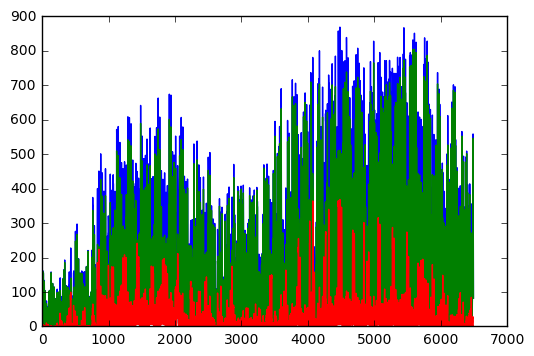

In [438]:
plt.plot(test_pred)
plt.plot(test_pred_registered)
plt.plot(test_pred_casual)

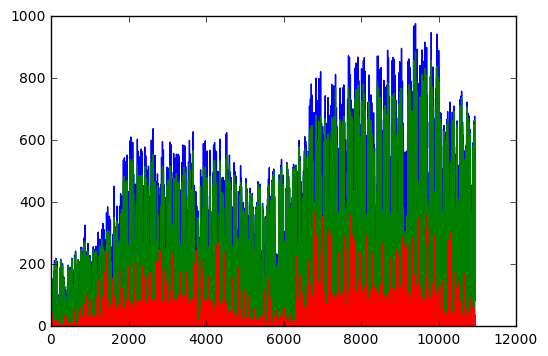

In [398]:
plt.plot(df[df['dataset']=='train']['count'].reset_index(drop=True))
plt.plot(df[df['dataset']=='train']['registered'].reset_index(drop=True))
plt.plot(df[df['dataset']=='train']['casual'].reset_index(drop=True))